In [12]:
#!pip install PyWavelets
#!pip install cvxpy
!pip install ECOS

In [4]:
import gdown
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pywt
from PIL import Image
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim, mean_squared_error
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#Downloading the Data
# Use folder ID from the link
folder_id = "17a09kkqVivZQFggCw9I_YboJ23tcexNM"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)

!rm -r /content/mini-imagenet/test.tar

!mkdir -p /content/mini-imagenet/train
!mkdir -p /content/mini-imagenet/val

!tar -xf /content/mini-imagenet/train.tar -C /content/mini-imagenet/train
!tar -xf /content/mini-imagenet/val.tar -C /content/mini-imagenet/val

!mv /content/mini-imagenet/val/val/* /content/mini-imagenet/val/
!rmdir /content/mini-imagenet/val/val

!mv /content/mini-imagenet/train/train/* /content/mini-imagenet/train/
!rmdir /content/mini-imagenet/train/train

Retrieving folder contents


Processing file 1yKyKgxcnGMIAnA_6Vr2ilbpHMc9COg-v test.tar
Processing file 107FTosYIeBn5QbynR46YG91nHcJ70whs train.tar
Processing file 1hSMUMj5IRpf-nQs1OwgiQLmGZCN0KDWl val.tar


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1yKyKgxcnGMIAnA_6Vr2ilbpHMc9COg-v
From (redirected): https://drive.google.com/uc?id=1yKyKgxcnGMIAnA_6Vr2ilbpHMc9COg-v&confirm=t&uuid=e169c295-1502-448c-a18f-73115af3bfaa
To: /content/mini-imagenet/test.tar
100%|██████████| 39.2M/39.2M [00:01<00:00, 28.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs
From (redirected): https://drive.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&confirm=t&uuid=e8c8db83-42ac-43bd-af4a-c77b498b4628
To: /content/mini-imagenet/train.tar
100%|██████████| 126M/126M [00:02<00:00, 48.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hSMUMj5IRpf-nQs1OwgiQLmGZCN0KDWl
From (redirected): https://drive.google.com/uc?id=1hSMUMj5IRpf-nQs1OwgiQLmGZCN0KDWl&confirm=t&uuid=4c2916f5-d219-492b-bf27-c3a7fbe0ecc8
To: /content/mini-i

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Use only the 64 training classes
full_dataset = datasets.ImageFolder('/content/mini-imagenet/train', transform=data_transforms['train'])

# Random split (e.g., 80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
}


NameError: name 'data_transforms' is not defined

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Data augmentation and normalization for training
# # Just normalization for validation
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((96, 96)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize((96, 96)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
#     ])
# }

# data_dir = '/content/mini-imagenet'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print("Dataset Size:", dataset_sizes)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load full dataset (only from /train)
data_dir = '/content/mini-imagenet/train'
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# Train/val split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Apply separate transforms using Subset and transform override
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Override transforms for val set
val_dataset.dataset.transform = val_transform

# Dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4),
}

# Sizes and classes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}
class_names = full_dataset.classes

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Dataset Size:", dataset_sizes)
print("Number of classes:", len(class_names))

Dataset Size: {'train': 30720, 'val': 7680}
Number of classes: 64


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


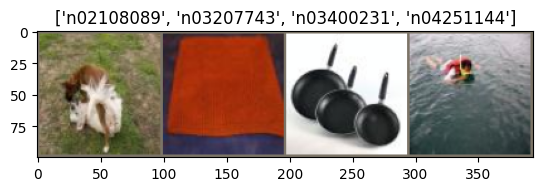

In [ ]:
#Vizulizing sample of the dataset
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
#Building function for the confusion matrix
def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)


    num_classes = len(class_names)
    fig_size = (num_classes * 0.25, num_classes * 0.25)

    plt.figure(figsize=fig_size)

    sns.heatmap(cm_df, annot=False, fmt='.2f', cmap='Blues', linewidths=0.01)

    plt.xticks(fontsize=2, rotation=90)
    plt.yticks(fontsize=2)

    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    plt.title('Normalized Confusion Matrix', fontsize=18)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


------------------------------------------------
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

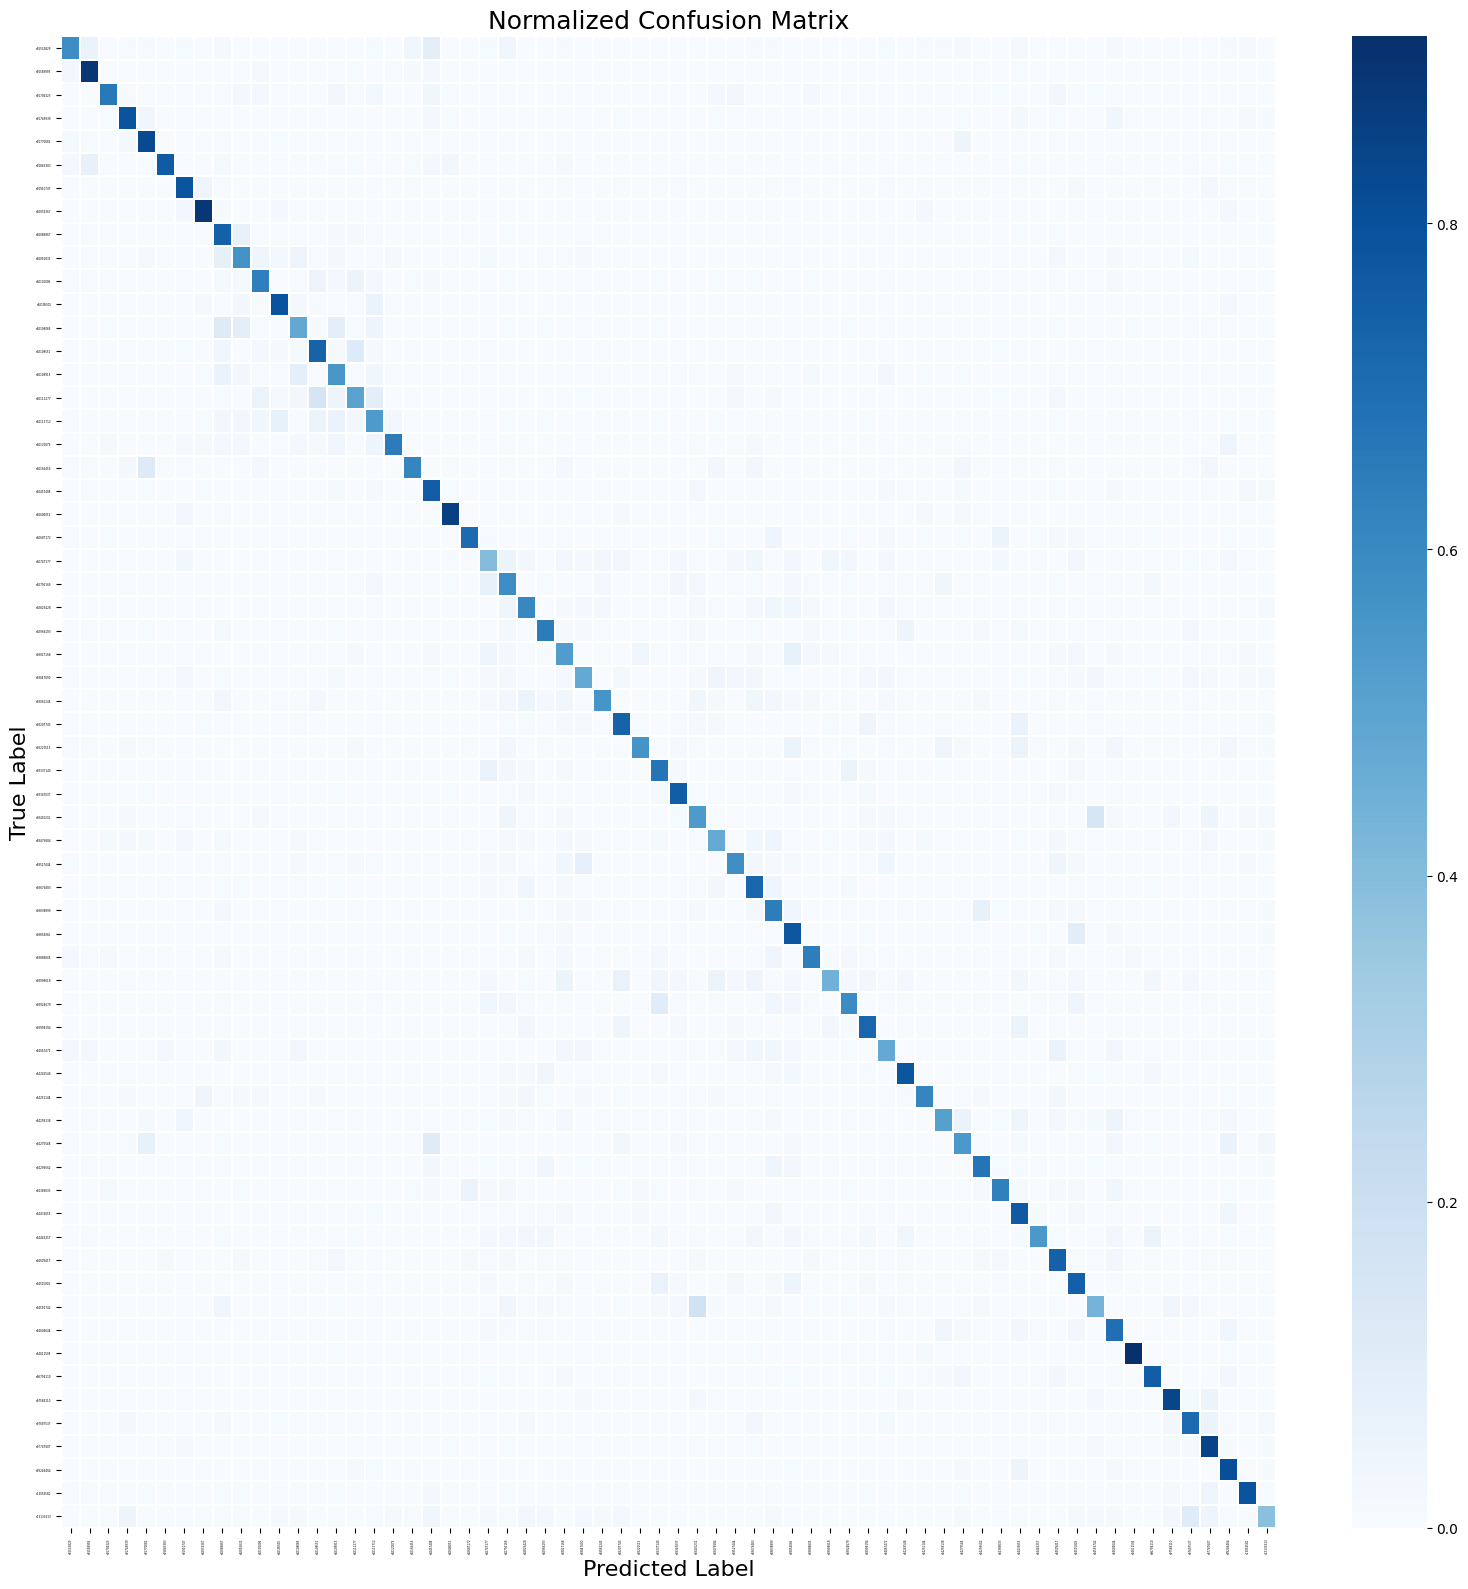

In [ ]:
#1.1Model Selection and Baseline Establishment: ResNet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)
print("-"*48)
print(model_ft)
print("-"*48)
num_epochs = 15
model = model_ft
optimizer = optimizer_ft

since = time.time()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

plot_confusion_matrix(model, dataloaders['val'], class_names)
torch.save(model, "model_original.pth")

In [ ]:
torch.save(model, "/content/drive/MyDrive/model_original.pth")


In [ ]:
#12.Model Selection and Baseline Establishment: MobileNet

model_ft = models.mobilenet_v3_large(pretrained=True)
num_ftrs = model_ft.classifier[0].in_features
model_ft.fc = nn.Linear(num_ftrs, 100)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

num_epochs = 15
model = model_ft
optimizer = optimizer_ft

print("-"*48)
print(model_ft)
print("-"*48)

since = time.time()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

plot_confusion_matrix(model, dataloaders['val'], class_names)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 111MB/s] 

------------------------------------------------
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Con

KeyboardInterrupt: 

In [9]:
#2.1 Wavelet-based Image Compression: Implement wavelet transform for image compression

def wavelet_compress(image, wavelet='haar', level=2, ratio=0.1):
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    flat = arr.flatten()

    thresh_index = int(len(flat) * (1 - ratio))
    thresh_value = np.partition(np.abs(flat), thresh_index)[thresh_index]

    arr_thresh = pywt.threshold(arr, thresh_value, mode='hard')
    coeffs_thresh = pywt.array_to_coeffs(arr_thresh, coeff_slices, output_format='wavedec2')
    compressed = pywt.waverec2(coeffs_thresh, wavelet=wavelet)

    return np.clip(compressed, 0, 255)

def save_image(array, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    img = Image.fromarray(np.uint8(array))
    img.save(path)

def compress_and_save_by_class(ToV,input_dir, output_root, ratios=[0.1, 0.2, 0.5], csv_out="compression_results.csv"):
    results = []

    for ratio in ratios:
        print(f"\nCompressing with ratio {int(1/ratio)}:1")
        for root, _, files in tqdm(os.walk(input_dir), desc=f"Ratio {int(1/ratio)}:1"):
            for fname in files:
                if not fname.lower().endswith((".jpg", ".png")):
                    continue
                try:
                    # Full input path
                    in_path = os.path.join(root, fname)

                    # Load and preprocess
                    img = Image.open(in_path).resize((84, 84)).convert("L")
                    img_np = np.array(img, dtype=np.float32)

                    # Compress
                    compressed_np = wavelet_compress(img_np, ratio=ratio)

                    # Path logic: preserve subfolder structure
                    relative_path = os.path.relpath(in_path, input_dir)
                    out_path = os.path.join(output_root, f"ratio_{int(1/ratio)}/{ToV}", relative_path)
                    save_image(compressed_np, out_path)

                    # Metrics
                    ssim_val = ssim(img_np, compressed_np, data_range=255)
                    mse_val = mean_squared_error(img_np, compressed_np)

                    results.append({
                        "file": relative_path,
                        "ratio": ratio,
                        "ssim": ssim_val,
                        "mse": mse_val
                    })

                except Exception as e:
                    print(f"Error with {fname}: {e}")
                    continue


### implementing the compression
input_dir = "/content/mini-imagenet/train"
output_dir = "/content/compressed-mini-imagenet"
compress_and_save_by_class('train',input_dir, output_dir)

input_dir = "/content/mini-imagenet/val"
output_dir = "/content/compressed-mini-imagenet"
compress_and_save_by_class('val',input_dir, output_dir)



Compressing with ratio 10:1


Ratio 10:1: 65it [01:19,  1.23s/it]



Compressing with ratio 5:1


Ratio 5:1: 65it [01:19,  1.23s/it]



Compressing with ratio 2:1


Ratio 2:1: 65it [01:21,  1.25s/it]



Compressing with ratio 10:1


Ratio 10:1: 17it [00:20,  1.20s/it]



Compressing with ratio 5:1


Ratio 5:1: 17it [00:19,  1.17s/it]



Compressing with ratio 2:1


Ratio 2:1: 17it [00:20,  1.21s/it]


Dataset Size: {'train': 38400, 'val': 9600}


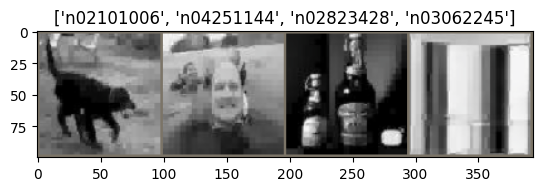

Epoch 0/1
----------
train Loss: 2.9728 Acc: 0.2708
val Loss: 7.6263 Acc: 0.0183

Epoch 1/1
----------
train Loss: 2.1825 Acc: 0.4369
val Loss: 8.6447 Acc: 0.0140

Training complete in 5m 9s


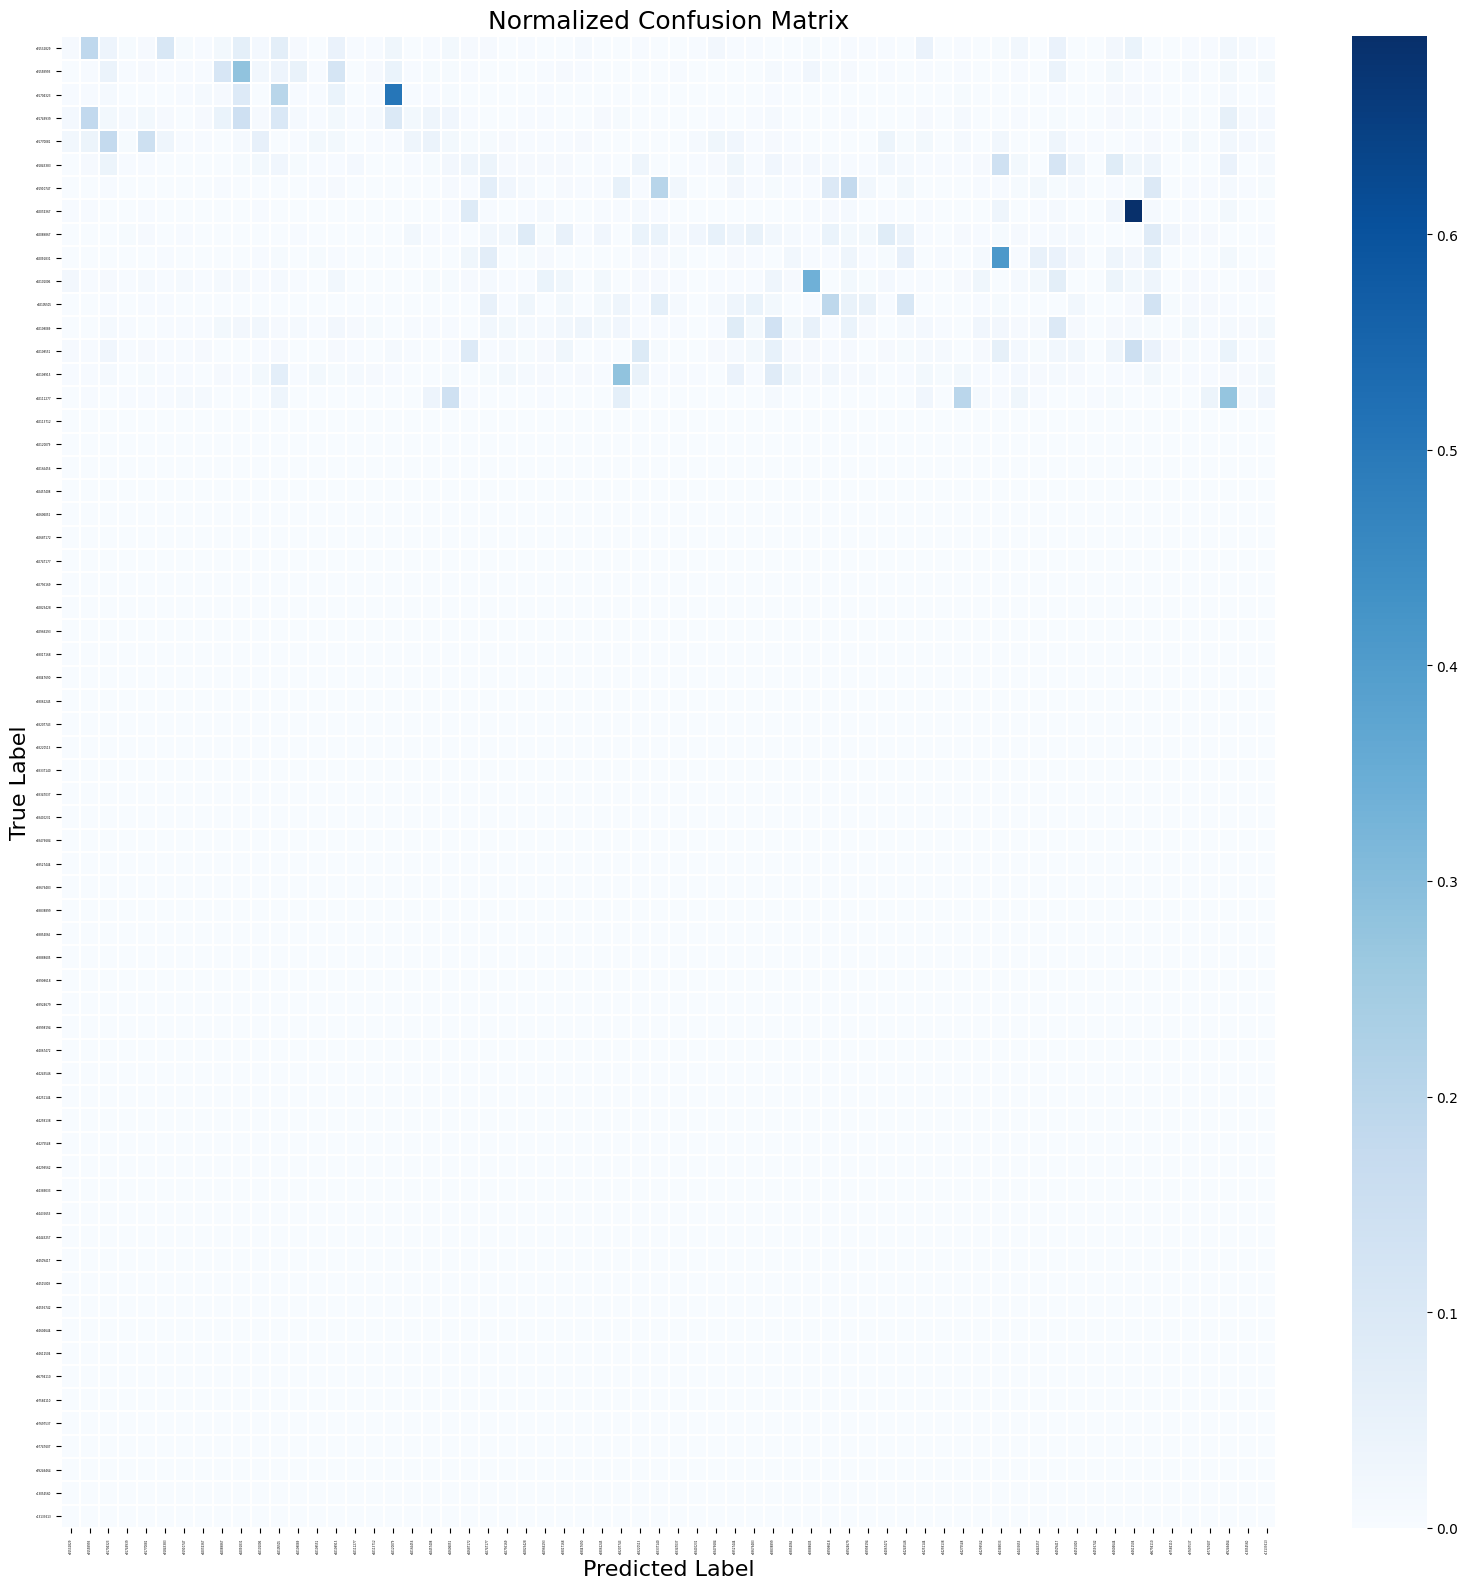

In [ ]:
#2. Evaluate model performance degradation across compression levels: "ratio_10"

ratio = "ratio_10"

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ])
}

data_dir = f'/content/compressed-mini-imagenet/{ratio}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Dataset Size:", dataset_sizes)

##
# Vizulizing
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


##
#Training

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 100)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

num_epochs = 2
model = model_ft
optimizer = optimizer_ft



since = time.time()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

plot_confusion_matrix(model, dataloaders['val'], class_names)


In [ ]:
#2. Evaluate model performance degradation across compression levels: "ratio_5"
ratio = "ratio_5"

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ])
}

data_dir = f'/content/compressed-mini-imagenet/{ratio}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Dataset Size:", dataset_sizes)

##
# Vizulizing
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


##
#Training

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 100)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

num_epochs = 2
model = model_ft
optimizer = optimizer_ft



since = time.time()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

plot_confusion_matrix(model, dataloaders['val'], class_names)


In [ ]:
#2. Evaluate model performance degradation across compression levels: "ratio_2"
ratio = "ratio_2"

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ])
}

data_dir = f'/content/compressed-mini-imagenet/{ratio}'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Dataset Size:", dataset_sizes)

##
# Vizulizing
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


##
#Training

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 100)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

num_epochs = 2
model = model_ft
optimizer = optimizer_ft



since = time.time()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

plot_confusion_matrix(model, dataloaders['val'], class_names)


In [8]:
# Path to compressed training dataset x10
compressed_train_dir = '/content/compressed-mini-imagenet/ratio_10'

# Basic transform for input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load compressed training dataset
compressed_train_dataset_10 = datasets.ImageFolder(compressed_train_dir, transform=transform)
compressed_train_loader_10 = DataLoader(compressed_train_dataset_10, batch_size=64, shuffle=True)

print(f"Loaded {len(compressed_train_dataset_10)} compressed training images.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/compressed-mini-imagenet/ratio_10'

In [ ]:
# Load a pre-trained ResNet18 and modify the final layer x10
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 100)  # Mini-ImageNet has 100 classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training config
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5  # increase as needed

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in compressed_train_loader_10:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")
torch.save(model, "model_wavelet.pth")
torch.save(model, "/content/drive/MyDrive/model_wavelet.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 478.0983, Accuracy: 78.88%
Epoch [2/5], Loss: 241.3140, Accuracy: 86.46%
Epoch [3/5], Loss: 155.8715, Accuracy: 91.68%
Epoch [4/5], Loss: 82.2601, Accuracy: 95.76%
Epoch [5/5], Loss: 51.0324, Accuracy: 97.39%


In [ ]:
import pickle
def evaluate(model, dataloader, description="Test"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"{description} Accuracy: {acc:.2f}%")
    return acc

#Evaluate on compressed test sets
acc10 = evaluate(model, compressed_train_loader_10, description="/content/compressed-mini-imagenet/ratio_10")

with open("accuracy.pkl", "wb") as f:
    pickle.dump(acc10, f)

/content/compressed-mini-imagenet/ratio_10 Accuracy: 98.24%


In [ ]:
# Path to compressed training dataset 5
compressed_train_dir = '/content/compressed-mini-imagenet/ratio_5'

# Basic transform for input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load compressed training dataset
compressed_train_dataset_5 = datasets.ImageFolder(compressed_train_dir, transform=transform)
compressed_train_loader_5 = DataLoader(compressed_train_dataset_5, batch_size=64, shuffle=True)

print(f"Loaded {len(compressed_train_dataset_5)} compressed training images.")


Loaded 48000 compressed training images.


In [ ]:
# Load a pre-trained ResNet18 and modify the final layer 5
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 100)  # Mini-ImageNet has 100 classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training config
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5  # increase as needed

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in compressed_train_loader_5:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch [1/5], Loss: 413.5405, Accuracy: 80.96%
Epoch [2/5], Loss: 207.7050, Accuracy: 88.49%
Epoch [3/5], Loss: 123.7898, Accuracy: 93.36%
Epoch [4/5], Loss: 65.8953, Accuracy: 96.62%
Epoch [5/5], Loss: 46.4620, Accuracy: 97.67%


In [ ]:
def evaluate(model, dataloader, description="Test"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"{description} Accuracy: {acc:.2f}%")
    return acc

#Evaluate on compressed test sets
acc5 = evaluate(model, compressed_train_loader_5, description="/content/compressed-mini-imagenet/ratio_5")
with open("accuracy.pkl1", "wb") as f:
    pickle.dump(acc5, f)

/content/compressed-mini-imagenet/ratio_5 Accuracy: 98.99%


In [ ]:
# Path to compressed training dataset 2
compressed_train_dir = '/content/compressed-mini-imagenet/ratio_2'

# Basic transform for input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load compressed training dataset
compressed_train_dataset_2 = datasets.ImageFolder(compressed_train_dir, transform=transform)
compressed_train_loader_2 = DataLoader(compressed_train_dataset_2, batch_size=64, shuffle=True)

print(f"Loaded {len(compressed_train_dataset_2)} compressed training images.")


Loaded 48000 compressed training images.


In [ ]:
# Load a pre-trained ResNet18 and modify the final layer 2
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 100)  # Mini-ImageNet has 100 classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training config
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 5  # increase as needed

# Fine-tuning loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in compressed_train_loader_2:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")


Epoch [1/5], Loss: 467.3205, Accuracy: 79.80%
Epoch [2/5], Loss: 204.1410, Accuracy: 88.84%
Epoch [3/5], Loss: 121.6134, Accuracy: 93.59%
Epoch [4/5], Loss: 65.4523, Accuracy: 96.64%
Epoch [5/5], Loss: 44.1865, Accuracy: 97.80%


In [ ]:
def evaluate(model, dataloader, description="Test"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"{description} Accuracy: {acc:.2f}%")
    return acc

#Evaluate on compressed test sets
acc2=evaluate(model, compressed_train_loader_2, description="/content/compressed-mini-imagenet/ratio_2")
with open("accuracy.pkl2", "wb") as f:
    pickle.dump(acc2, f)

/content/compressed-mini-imagenet/ratio_2 Accuracy: 98.92%


In [ ]:
import pandas as pd

with open("accuracy.pkl", "rb") as f:
    saved_acc10 = pickle.load(f)
with open("accuracy.pkl1", "rb") as f:
    saved_acc5 = pickle.load(f)

with open("accuracy.pkl2", "rb") as f:
    saved_acc2 = pickle.load(f)


# Manually enter your results
results = [
    {"Model": "ResNet18", "Train Compression": "10:1",  "Test (Compressed)": saved_acc10},
    {"Model": "ResNet18", "Train Compression": "5:1",  "Test (Compressed)": saved_acc5},
    {"Model": "ResNet18", "Train Compression": "2:1", "Test (Compressed)": saved_acc2},
]

# Create and display DataFrame
df = pd.DataFrame(results)
display(df)


,Model,Train Compression,Test (Compressed)
0,ResNet18,10:1,98.241667
1,ResNet18,5:1,98.993750
2,ResNet18,2:1,98.916667


In [2]:
# Download and extract mini-imagenet data from Google Drive
!pip install -U gdown

import gdown

folder_id = "17a09kkqVivZQFggCw9I_YboJ23tcexNM"
gdown.download_folder(f"https://drive.google.com/drive/folders/{folder_id}", quiet=False, use_cookies=False)

# Create directories for extraction
!mkdir -p /content/mini-imagenet/train
!mkdir -p /content/mini-imagenet/val
!mkdir -p /content/mini-imagenet/test

# Extract the .tar files
!tar -xf /content/mini-imagenet/train.tar -C /content/mini-imagenet/train
!tar -xf /content/mini-imagenet/val.tar -C /content/mini-imagenet/val
!tar -xf /content/mini-imagenet/test.tar -C /content/mini-imagenet/test


Retrieving folder contents


Processing file 1yKyKgxcnGMIAnA_6Vr2ilbpHMc9COg-v test.tar
Processing file 107FTosYIeBn5QbynR46YG91nHcJ70whs train.tar
Processing file 1hSMUMj5IRpf-nQs1OwgiQLmGZCN0KDWl val.tar


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1yKyKgxcnGMIAnA_6Vr2ilbpHMc9COg-v
From (redirected): https://drive.google.com/uc?id=1yKyKgxcnGMIAnA_6Vr2ilbpHMc9COg-v&confirm=t&uuid=ff704782-ecc0-4d9c-9628-3a6948b14eb7
To: /content/mini-imagenet/test.tar
100%|██████████| 39.2M/39.2M [00:01<00:00, 38.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs
From (redirected): https://drive.google.com/uc?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&confirm=t&uuid=7935b44a-d869-448d-b479-96a095897a23
To: /content/mini-imagenet/train.tar
100%|██████████| 126M/126M [00:02<00:00, 61.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1hSMUMj5IRpf-nQs1OwgiQLmGZCN0KDWl
From (redirected): https://drive.google.com/uc?id=1hSMUMj5IRpf-nQs1OwgiQLmGZCN0KDWl&confirm=t&uuid=1c6ab79a-d2c6-4933-b13d-2976cbac3811
To: /content/mini-i

In [1]:
#Import Libraries and setup
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import random
from PIL import Image
from collections import defaultdict

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax

from sklearn.linear_model import OrthogonalMatchingPursuit, Lasso

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)


Device in use: cpu


✅ Selected 20 images from 20 different classes


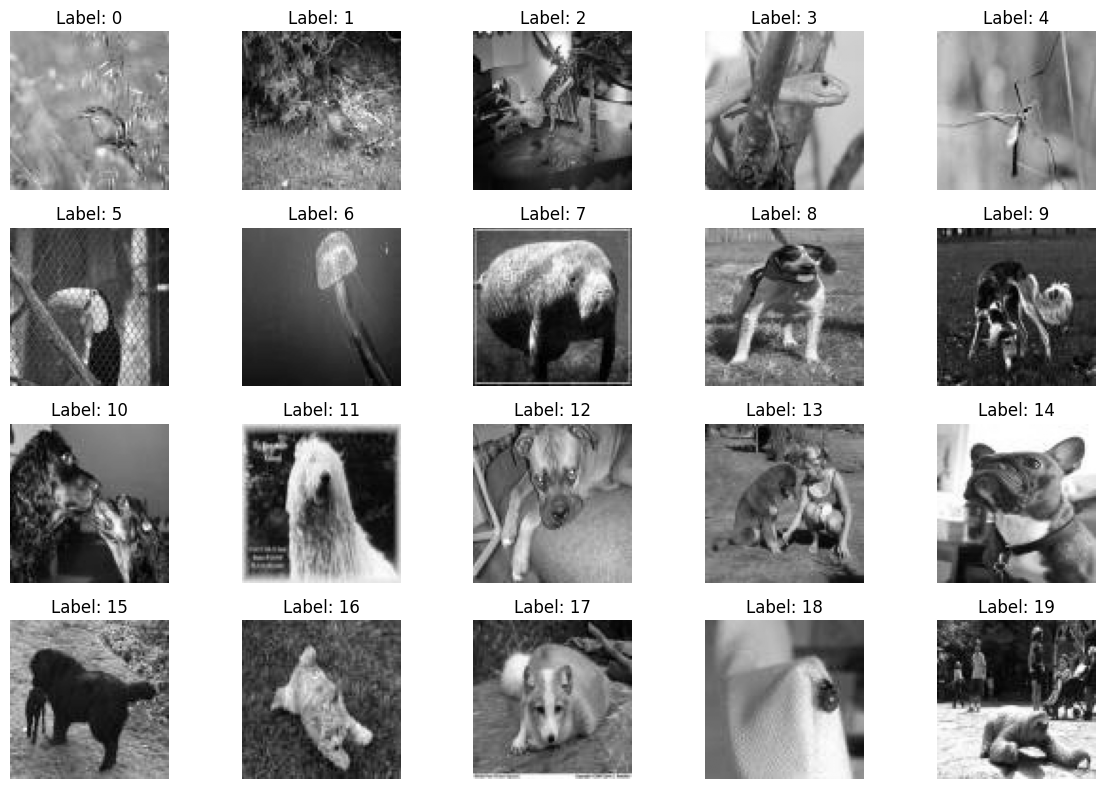

In [40]:
# Load 20 images from the test set
transform = transforms.Compose([
transforms.Grayscale(),
transforms.Resize((84, 84)),
transforms.ToTensor()
])


# Load 20 images from 20 different classes from the real path
train_dataset_path = '/content/mini-imagenet/train/train'

train_dataset = ImageFolder(root=train_dataset_path, transform=transform)

# Select one image from each class
selected_images = []
selected_labels = []
seen_classes = set()

for img, label in train_dataset:
    if label not in seen_classes:
        selected_images.append(img.squeeze().numpy())
        selected_labels.append(label)
        seen_classes.add(label)
    if len(selected_images) >= 20:
        break

print(f"✅ Selected {len(selected_images)} images from {len(set(selected_labels))} different classes")

# Display them
fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i], cmap='gray')
    ax.set_title(f"Label: {selected_labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()





In [29]:
# Define functions (OMP,LASSO,Evaluation)
def reconstruct_omp(Phi, y, n_nonzero_coefs=100):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
    omp.fit(Phi, y)
    return omp.coef_

def reconstruct_lasso(Phi, y, alpha=0.0001):
    lasso = Lasso(alpha=alpha, max_iter=5000)
    lasso.fit(Phi, y)
    return lasso.coef_

def evaluate_model(model, images):
    predictions = []
    with torch.no_grad():
        for img in images:
            img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
            img_tensor = img_tensor.unsqueeze(0).to(device)

            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
            img_tensor = (img_tensor - mean) / std

            output = model(img_tensor)
            pred = torch.argmax(softmax(output, dim=1)).item()
            predictions.append(pred)
    return predictions

def compute_accuracy(preds, labels):
    return sum(p == l for p, l in zip(preds, labels)) / len(labels)

def compute_class_wise_accuracy(preds, labels):
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for p, l in zip(preds, labels):
        class_total[l] += 1
        if p == l:
            class_correct[l] += 1

    class_acc = {cls: round(class_correct[cls]/class_total[cls]*100, 2) if class_total[cls] else 0
                 for cls in class_total}
    return class_acc


In [8]:
# Load Pre-trained models
model_original = torch.load("/content/drive/MyDrive/model_original.pth", map_location=device, weights_only=False).to(device).eval()
model_wavelet = torch.load("/content/drive/MyDrive/model_wavelet.pth", map_location=device, weights_only=False).to(device).eval()


In [42]:
# Reconstruction using OMP

sampling_rates = [0.25, 0.5, 0.75]
image_size = 84
N = image_size * image_size

reconstructed_images_omp = {}

for rate in sampling_rates:
    M = int(rate * N)
    Phi = np.random.randn(M, N) / np.sqrt(M)
    reconstructed_images_omp[rate] = []

    for img in selected_images:
        x = img.flatten()
        y = Phi @ x
        x_hat = reconstruct_omp(Phi, y, n_nonzero_coefs=int(0.05 * N))
        print(f"x_hat max: {x_hat.max():.4f}, min: {x_hat.min():.4f}, mean: {x_hat.mean():.4f}")
        img_recon = np.clip(x_hat.reshape((84, 84)), 0, 1)
        reconstructed_images_omp[rate].append(img_recon)


x_hat max: 5.2788, min: -4.4298, mean: 0.0908
x_hat max: 5.2864, min: -3.3177, mean: 0.0607
x_hat max: 4.5672, min: -3.0751, mean: 0.0682
x_hat max: 6.3050, min: -6.6557, mean: 0.1022
x_hat max: 6.2877, min: -3.9912, mean: 0.0952
x_hat max: 4.6325, min: -3.9783, mean: 0.0610
x_hat max: 2.7878, min: -2.2791, mean: 0.0419
x_hat max: 5.0826, min: -4.1249, mean: 0.0752
x_hat max: 5.7204, min: -4.1692, mean: 0.0792
x_hat max: 3.3474, min: -2.6811, mean: 0.0416
x_hat max: 3.5643, min: -3.2902, mean: 0.0497
x_hat max: 5.9362, min: -4.4786, mean: 0.0815
x_hat max: 6.0125, min: -4.2513, mean: 0.0857
x_hat max: 4.8161, min: -3.5043, mean: 0.0714
x_hat max: 7.5780, min: -4.8581, mean: 0.0912
x_hat max: 5.4732, min: -3.6874, mean: 0.0771
x_hat max: 2.8346, min: -2.2222, mean: 0.0461
x_hat max: 5.0830, min: -3.8786, mean: 0.0814
x_hat max: 5.3413, min: -3.3272, mean: 0.0826
x_hat max: 6.5607, min: -4.6004, mean: 0.0774
x_hat max: 3.7363, min: -2.3230, mean: 0.0875
x_hat max: 2.7918, min: -1.9058, m

In [43]:
# Reconstruction using LASSO
reconstructed_images_lasso = {}

for rate in sampling_rates:
    M = int(rate * N)
    Phi = np.random.randn(M, N) / np.sqrt(M)
    reconstructed_images_lasso[rate] = []

    for img in selected_images:
        x = img.flatten()
        y = Phi @ x
        x_hat = reconstruct_lasso(Phi, y)
        print(f"x_hat max: {x_hat.max():.4f}, min: {x_hat.min():.4f}, mean: {x_hat.mean():.4f}")
        img_recon = np.clip(x_hat.reshape((84, 84)), 0, 1)
        reconstructed_images_lasso[rate].append(img_recon)


x_hat max: 2.9778, min: -2.2589, mean: 0.1001
x_hat max: 2.3078, min: -1.6043, mean: 0.0656
x_hat max: 2.3394, min: -1.9244, mean: 0.0643
x_hat max: 4.1521, min: -2.7943, mean: 0.1078
x_hat max: 3.5549, min: -2.5275, mean: 0.1182
x_hat max: 2.3326, min: -1.9722, mean: 0.0709
x_hat max: 1.6712, min: -1.0108, mean: 0.0431
x_hat max: 2.8935, min: -1.9667, mean: 0.0743
x_hat max: 2.9613, min: -2.3316, mean: 0.0907
x_hat max: 1.6153, min: -1.0343, mean: 0.0433
x_hat max: 1.6415, min: -1.3100, mean: 0.0487
x_hat max: 3.3011, min: -1.9012, mean: 0.0896
x_hat max: 3.7879, min: -2.4514, mean: 0.1000
x_hat max: 3.0722, min: -1.5407, mean: 0.0783
x_hat max: 3.5753, min: -2.4421, mean: 0.1146
x_hat max: 2.5300, min: -1.8035, mean: 0.0839
x_hat max: 1.5256, min: -1.1586, mean: 0.0452
x_hat max: 2.9336, min: -1.7073, mean: 0.0876
x_hat max: 2.5446, min: -2.1303, mean: 0.0840
x_hat max: 2.8768, min: -2.0365, mean: 0.0843
x_hat max: 2.6603, min: -0.8843, mean: 0.1178
x_hat max: 1.5100, min: -0.9176, m

In [44]:
# Evaluate and compare
results = []

for rate in sampling_rates:
    preds_omp_orig = evaluate_model(model_original, reconstructed_images_omp[rate])
    preds_omp_wave = evaluate_model(model_wavelet, reconstructed_images_omp[rate])
    acc_omp_orig = compute_accuracy(preds_omp_orig, selected_labels)
    acc_omp_wave = compute_accuracy(preds_omp_wave, selected_labels)

    preds_lasso_orig = evaluate_model(model_original, reconstructed_images_lasso[rate])
    preds_lasso_wave = evaluate_model(model_wavelet, reconstructed_images_lasso[rate])
    acc_lasso_orig = compute_accuracy(preds_lasso_orig, selected_labels)
    acc_lasso_wave = compute_accuracy(preds_lasso_wave, selected_labels)

    results.append((rate, acc_omp_orig, acc_omp_wave, acc_lasso_orig, acc_lasso_wave))

df = pd.DataFrame(results, columns=["Sampling Rate", "OMP Original", "OMP Wavelet", "Lasso Original", "Lasso Wavelet"])
df = (df * 100).round(2)
print(df.to_string(index=False))


 Sampling Rate  OMP Original  OMP Wavelet  Lasso Original  Lasso Wavelet
          25.0           0.0          5.0             0.0            5.0
          50.0           0.0          5.0             0.0            5.0
          75.0           0.0          5.0             0.0            5.0


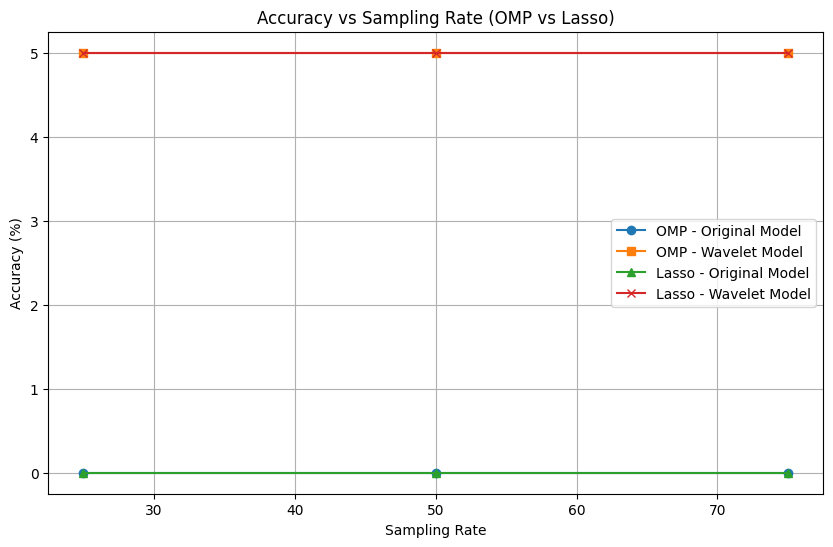

In [45]:
# Plot result
plt.figure(figsize=(10, 6))
plt.plot(df["Sampling Rate"], df["OMP Original"], marker='o', label="OMP - Original Model")
plt.plot(df["Sampling Rate"], df["OMP Wavelet"], marker='s', label="OMP - Wavelet Model")
plt.plot(df["Sampling Rate"], df["Lasso Original"], marker='^', label="Lasso - Original Model")
plt.plot(df["Sampling Rate"], df["Lasso Wavelet"], marker='x', label="Lasso - Wavelet Model")
plt.title("Accuracy vs Sampling Rate (OMP vs Lasso)")
plt.xlabel("Sampling Rate")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()


In [46]:
# Class-Wise Accuracy for Best Result
rate = 0.5
preds = evaluate_model(model_wavelet, reconstructed_images_omp[rate])
class_acc = compute_class_wise_accuracy(preds, selected_labels)

print(f"Class-wise Accuracy (Wavelet Model @ {rate*100}% - OMP):")
for k, v in sorted(class_acc.items()):
    print(f"Class {k}: {v}%")


Class-wise Accuracy (Wavelet Model @ 50.0% - OMP):
Class 0: 100.0%
Class 1: 0.0%
Class 2: 0.0%
Class 3: 0.0%
Class 4: 0.0%
Class 5: 0.0%
Class 6: 0.0%
Class 7: 0.0%
Class 8: 0.0%
Class 9: 0.0%
Class 10: 0.0%
Class 11: 0.0%
Class 12: 0.0%
Class 13: 0.0%
Class 14: 0.0%
Class 15: 0.0%
Class 16: 0.0%
Class 17: 0.0%
Class 18: 0.0%
Class 19: 0.0%


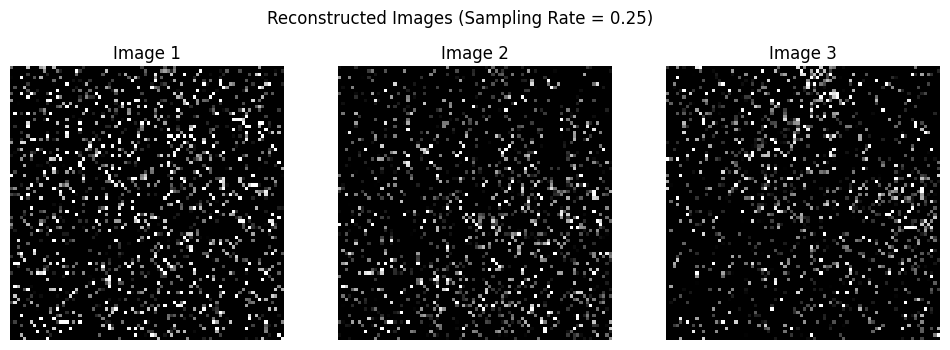

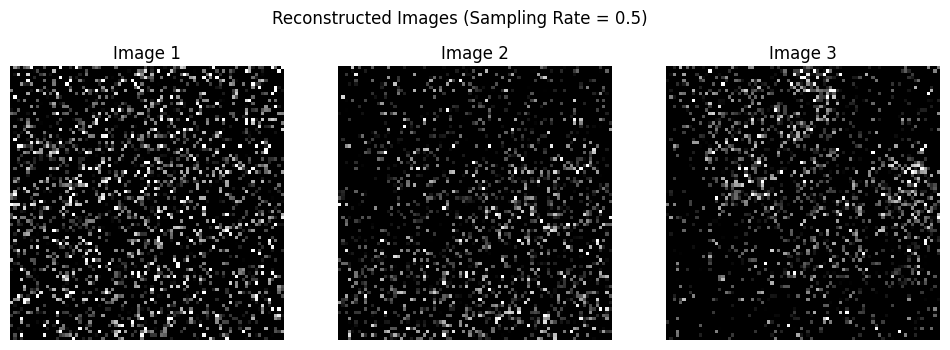

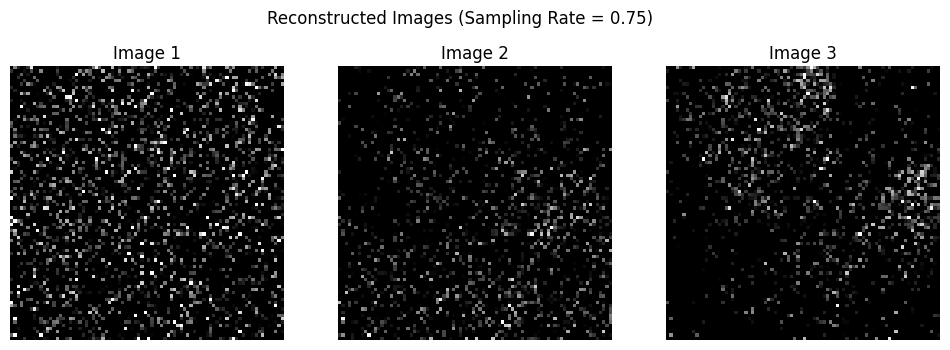

In [47]:
import matplotlib.pyplot as plt

for rate in sampling_rates:
    imgs = reconstructed_images_lasso[rate]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Reconstructed Images (Sampling Rate = {rate})")

    for i in range(3):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.show()


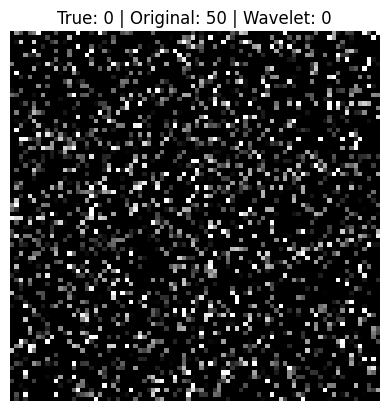

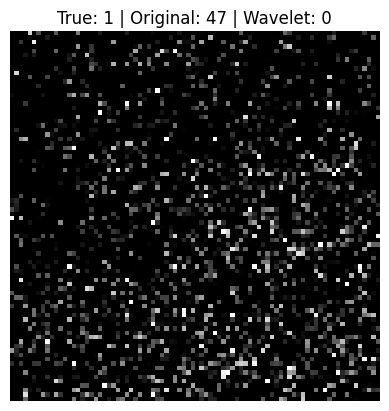

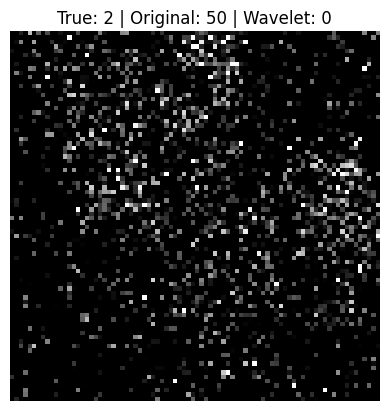

In [48]:
from torchvision.transforms.functional import to_pil_image

for i in range(3):  # بدل لـ 5 أو 20 إذا حبيت
    img = reconstructed_images_lasso[0.5][i]
    label = selected_labels[i]

    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        out_orig = model_original(img_tensor)
        out_wave = model_wavelet(img_tensor)
        pred_orig = torch.argmax(softmax(out_orig, dim=1)).item()
        pred_wave = torch.argmax(softmax(out_wave, dim=1)).item()

    plt.imshow(img, cmap='gray')
    plt.title(f"True: {label} | Original: {pred_orig} | Wavelet: {pred_wave}")
    plt.axis('off')
    plt.show()


In [49]:
# Check how many unique labels we have in the selected test images
unique_labels = set(selected_labels)
print(f"Number of unique labels: {len(unique_labels)}")
print(f"Labels: {sorted(unique_labels)}")


Number of unique labels: 20
Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


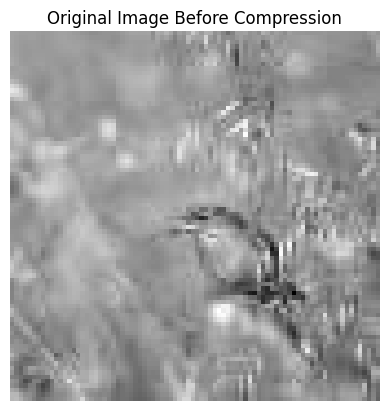

In [51]:
# Display a raw original image from the selected set
plt.imshow(selected_images[0], cmap='gray')
plt.title("Original Image Before Compression")
plt.axis('off')
plt.show()


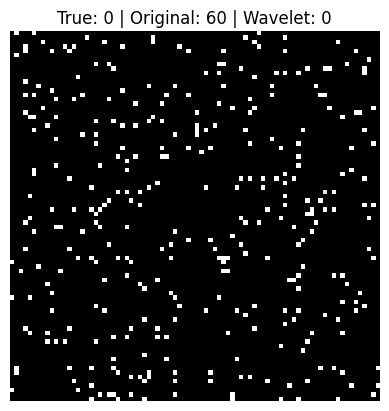

In [52]:
# Show model predictions for a reconstructed image
img = reconstructed_images_omp[0.5][0]  # Or lasso if using that

img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
img_tensor = img_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    out_orig = model_original(img_tensor)
    out_wave = model_wavelet(img_tensor)
    pred_orig = torch.argmax(softmax(out_orig, dim=1)).item()
    pred_wave = torch.argmax(softmax(out_wave, dim=1)).item()

plt.imshow(img, cmap='gray')
plt.title(f"True: {selected_labels[0]} | Original: {pred_orig} | Wavelet: {pred_wave}")
plt.axis('off')
plt.show()


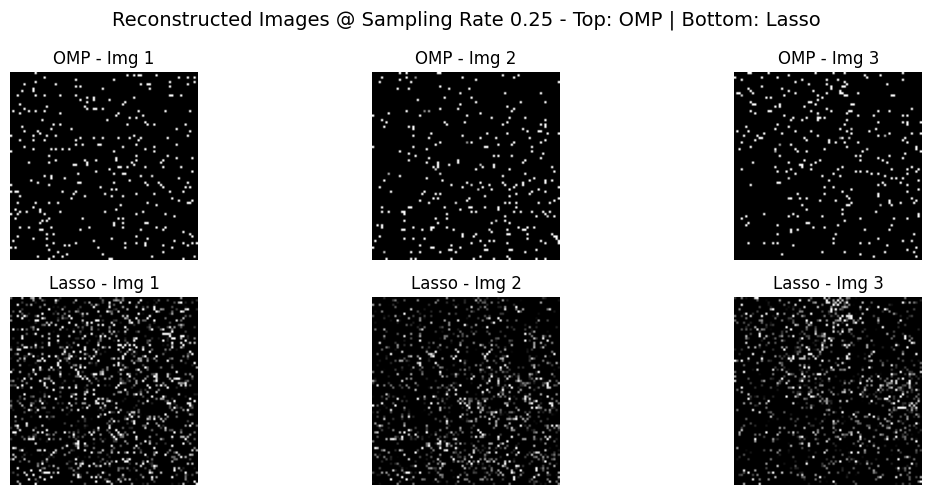

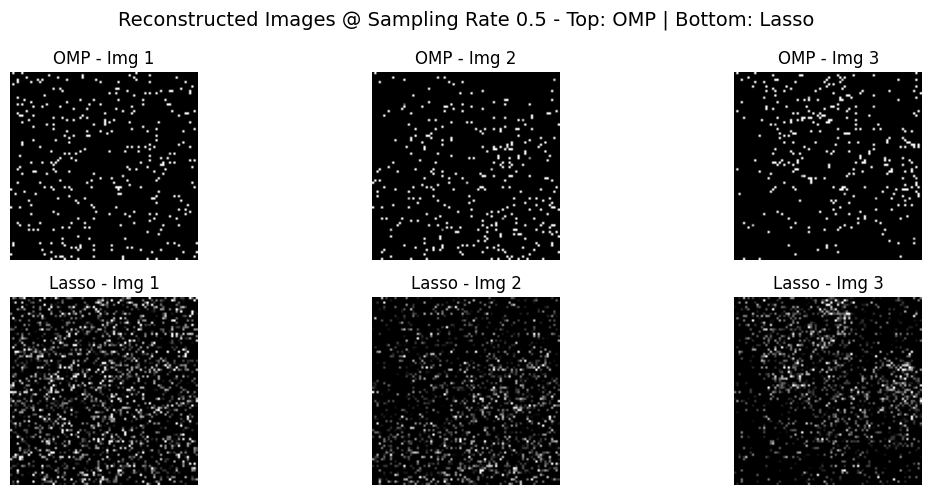

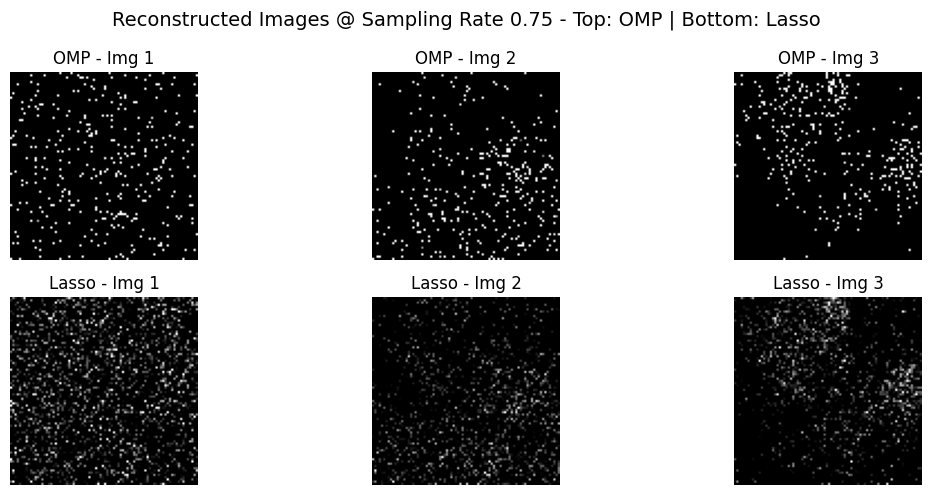

In [53]:
import matplotlib.pyplot as plt

sampling_rates = [0.25, 0.5, 0.75]
n_show = 3  # عدد الصور اللي بنعرضها لكل Sampling Rate

for rate in sampling_rates:
    fig, axs = plt.subplots(2, n_show, figsize=(12, 5))
    fig.suptitle(f"Reconstructed Images @ Sampling Rate {rate} - Top: OMP | Bottom: Lasso", fontsize=14)

    # Loop through number of images to show
    for i in range(n_show):
        # OMP
        axs[0, i].imshow(reconstructed_images_omp[rate][i], cmap='gray')
        axs[0, i].set_title(f"OMP - Img {i+1}")
        axs[0, i].axis('off')

        # Lasso
        axs[1, i].imshow(reconstructed_images_lasso[rate][i], cmap='gray')
        axs[1, i].set_title(f"Lasso - Img {i+1}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


In [56]:
print("Unique labels in selected_labels:", set(selected_labels))
print("Number of labels:", len(selected_labels))
print("Number of predictions:", len(preds))


Unique labels in selected_labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Number of labels: 20
Number of predictions: 20
